In [18]:
from google.colab import files
uploaded = files.upload()


Saving msmri_state_data.csv to msmri_state_data (1).csv


In [19]:
import pandas as pd

df = pd.read_csv("msmri_state_data.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                36 non-null     object 
 1   Year                 36 non-null     int64  
 2   Age_Group            36 non-null     object 
 3   Occupation_Group     36 non-null     object 
 4   Gender               36 non-null     object 
 5   Cause_of_Stress      36 non-null     object 
 6   Suicide_Deaths       36 non-null     int64  
 7   Population           36 non-null     int64  
 8   Death_Rate_per_100k  36 non-null     float64
dtypes: float64(1), int64(3), object(5)
memory usage: 2.7+ KB


In [20]:
#Data cleaning
df.isnull().sum()
df["Age_Group"] = df["Age_Group"].str.strip()
df["Cause_of_Stress"] = df["Cause_of_Stress"].str.strip()


In [21]:
#Eda
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", palette="viridis")


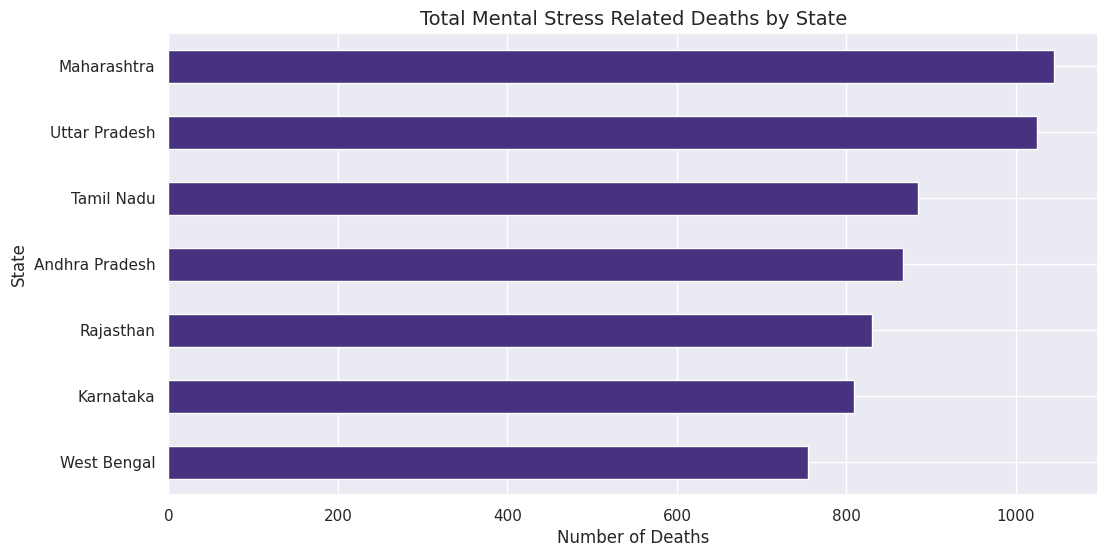

In [22]:
#state wise suicide deaths
plt.figure(figsize=(12,6))
state_deaths = df.groupby("State")["Suicide_Deaths"].sum().sort_values()
state_deaths.plot(kind="barh")

plt.title("Total Mental Stress Related Deaths by State", fontsize=14)
plt.xlabel("Number of Deaths")
plt.ylabel("State")
plt.show()


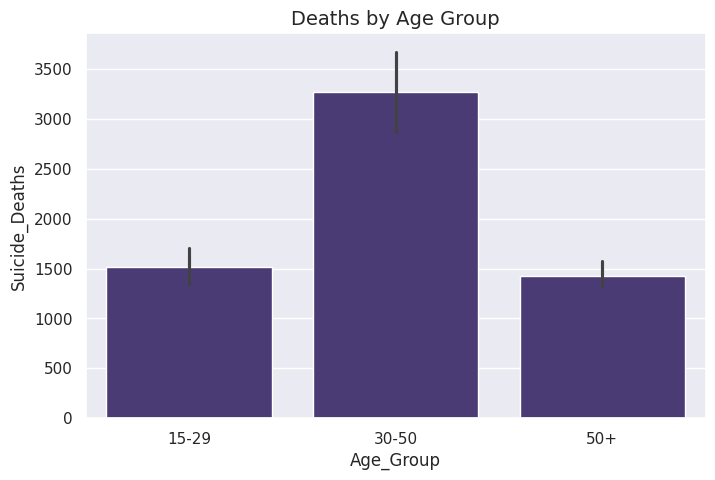

In [23]:
#age group vunerabilities

plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Age_Group", y="Suicide_Deaths", estimator=sum)

plt.title("Deaths by Age Group", fontsize=14)
plt.show()


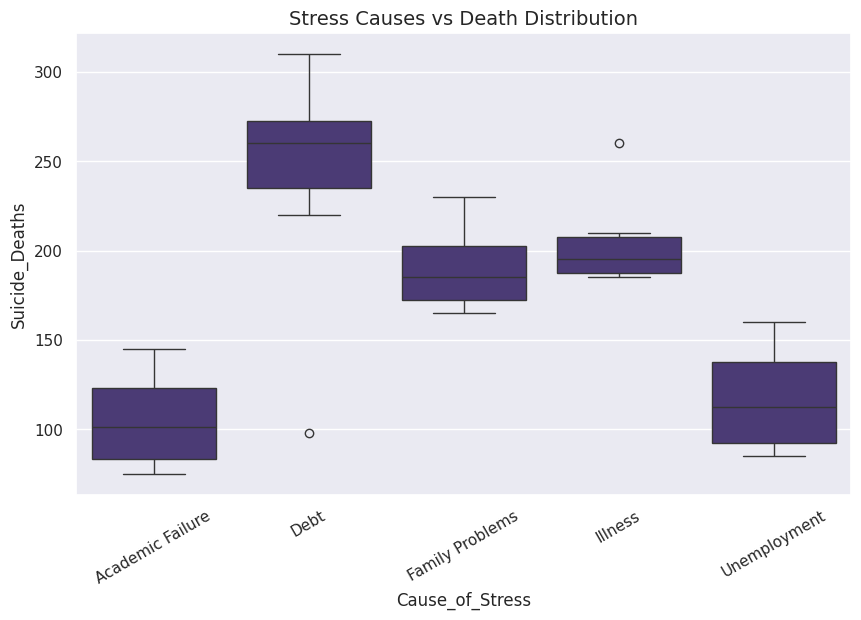

In [24]:
#cause based stress impact
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Cause_of_Stress", y="Suicide_Deaths")

plt.xticks(rotation=30)
plt.title("Stress Causes vs Death Distribution", fontsize=14)
plt.show()


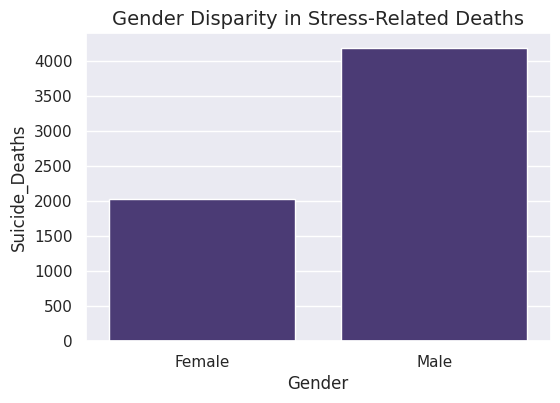

In [25]:
#gender disparity analysis
gender_df = df.groupby("Gender")["Suicide_Deaths"].sum().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=gender_df, x="Gender", y="Suicide_Deaths")

plt.title("Gender Disparity in Stress-Related Deaths", fontsize=14)
plt.show()


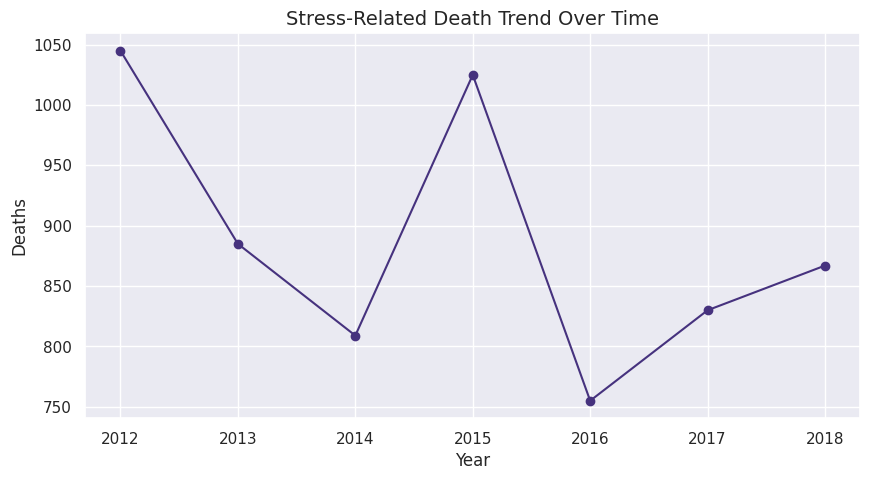

In [26]:
#time trend(stress escalation)
trend = df.groupby("Year")["Suicide_Deaths"].sum()

plt.figure(figsize=(10,5))
trend.plot(marker="o")

plt.title("Stress-Related Death Trend Over Time", fontsize=14)
plt.ylabel("Deaths")
plt.xlabel("Year")
plt.show()


In [27]:
#normalize death rate
df["Norm_Death_Rate"] = (
    (df["Death_Rate_per_100k"] - df["Death_Rate_per_100k"].min()) /
    (df["Death_Rate_per_100k"].max() - df["Death_Rate_per_100k"].min())
)


In [28]:
#vulnerability score
def vulnerability_score(row):
    if row["Age_Group"] == "15-29" or row["Occupation_Group"] == "Farmer":
        return 1.3
    elif row["Age_Group"] == "50+":
        return 1.2
    else:
        return 1.0

df["Vulnerability_Score"] = df.apply(vulnerability_score, axis=1)


In [29]:
#cause severity score
cause_weights = {
    "Debt": 1.4,
    "Academic Failure": 1.3,
    "Unemployment": 1.3,
    "Family Problems": 1.1,
    "Illness": 1.0
}

df["Cause_Severity"] = df["Cause_of_Stress"].map(cause_weights)


In [31]:
#gender disparity factor
gender_ratio = df.groupby("Gender")["Suicide_Deaths"].sum()
gender_factor = gender_ratio["Male"] / gender_ratio["Female"]

df["Gender_Factor"] = df["Gender"].apply(
    lambda x: gender_factor if x == "Male" else 1
)


In [32]:
df["MSMRI"] = (
    0.40 * df["Norm_Death_Rate"] +
    0.25 * df["Vulnerability_Score"] +
    0.20 * df["Cause_Severity"] +
    0.15 * df["Gender_Factor"]
)


In [33]:
df[["State","Year","MSMRI"]].head()


,State,Year,MSMRI
0,Maharashtra,2012,0.966027
1,Maharashtra,2012,0.759859
2,Maharashtra,2012,1.285085
3,Maharashtra,2012,0.837109
4,Maharashtra,2012,0.818870


In [34]:
#risk levels
def risk_level(msmri):
    if msmri >= 1.2:
        return "Critical"
    elif msmri >= 1.0:
        return "High"
    elif msmri >= 0.8:
        return "Moderate"
    else:
        return "Low"

df["Risk_Level"] = df["MSMRI"].apply(risk_level)


/tmp/ipython-input-1431760965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Risk_Level", palette="rocket")


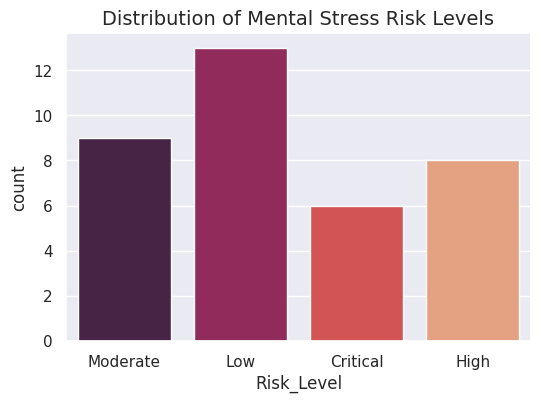

In [35]:
#define risk level
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Risk_Level", palette="rocket")

plt.title("Distribution of Mental Stress Risk Levels", fontsize=14)
plt.show()


/tmp/ipython-input-238388928.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Risk_Level", palette="rocket")


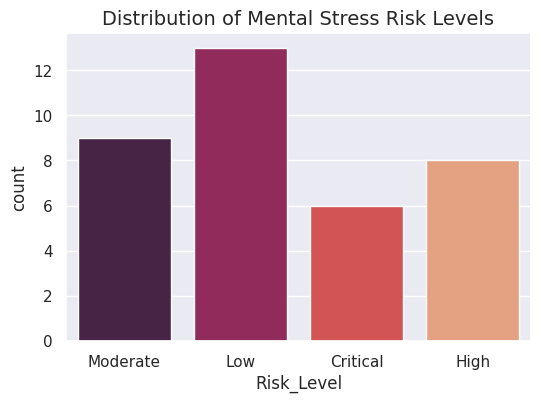

In [36]:
#risk disribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Risk_Level", palette="rocket")

plt.title("Distribution of Mental Stress Risk Levels", fontsize=14)
plt.show()


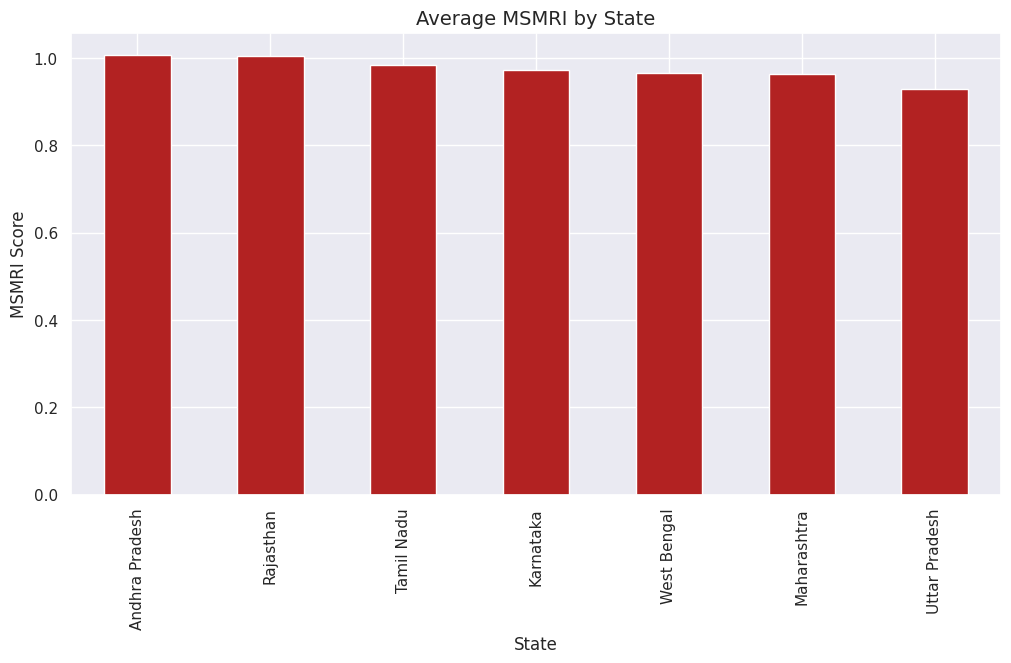

In [37]:
#state wise average risk
state_risk = df.groupby("State")["MSMRI"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
state_risk.plot(kind="bar", color="firebrick")

plt.title("Average MSMRI by State", fontsize=14)
plt.ylabel("MSMRI Score")
plt.show()
